-----------------------------------------------------------------------------------------
### Question
What were the top Australian news topics over the last decade, and what can these say about the national conversation?

### Data
Dataset used here is **'million ABC news headlines'** sources from https://www.kaggle.com/therohk/million-headlines. A million news headlines and its published date are provided in this dataset from 2003 until 2020.

### Analysis:
ABC News is a public news service provider in Australia. Their news service cover multiple topics including 'politics, World, Business, Analysis, Sport, Science, Health, Arts and other."(sourced from: https://www.abc.net.au/news/ )

To understand the top national topics, we would like to know **which news are mostly reported by ABC**. This can be achieved through **counting the most frequent occured terms(term frequency) and 'tfidf'(inverted term frequency)**, which weight the importance of terms among a set of ducoments. 

Firstly, let's take a look at the dataset.

In [57]:
#read the csv file
My_news_tilte = pd.read_csv('abcnews-date-text.csv', sep = ',', parse_dates=[0], infer_datetime_format=True)
print(My_news_tilte.head())
My_news_tilte.info()
#[1186018 rows x 2 columns] 

  publish_date                                      headline_text
0   2003-02-19  aba decides against community broadcasting lic...
1   2003-02-19     act fire witnesses must be aware of defamation
2   2003-02-19     a g calls for infrastructure protection summit
3   2003-02-19           air nz staff in aust strike for pay rise
4   2003-02-19      air nz strike to affect australian travellers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 2 columns):
publish_date     1186018 non-null datetime64[ns]
headline_text    1186018 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 18.1+ MB


### Data cleanning
- From the dataset we can see that, this dataset is **incredibly large**(18.1+MB, more than 1 billion rows), the headline_text is started from 2003. Since we only interested about news of the last 10 years, the first thing we need is to **extract the data for only 2010-2019**. 

In [58]:
#We can use datetime to extract the decade news titles 
decade_data = My_news_tilte[My_news_tilte['publish_date'].dt.year >= 2010]
decade_data


,publish_date,headline_text
510305,2010-01-01,12m degas stolen from museum
510306,2010-01-01,17 die in bangladesh bus crash
510307,2010-01-01,2010 to be drier after very wet 2009
510308,2010-01-01,37 catholic workers killed worldwide
510309,2010-01-01,600 hurt in philippine new year revelry
...,...,...
1186013,2019-12-31,vision of flames approaching corryong in victoria
1186014,2019-12-31,wa police and government backflip on drug amne...
1186015,2019-12-31,we have fears for their safety: victorian premier
1186016,2019-12-31,when do the 20s start


### Data cleanning
The 10 years data is still quite big(more than 675k rows), this may cause difficulty for the later analysis with tf or tfidf, since the weight of single terms can hardly give us useful information among such a big dataset. 

Before finding ways to **reduce the data dimension**, first, let's **take a look at the distribution of headlines within last decade**. 


In [59]:
#first resample the date to arrange them according to years 
reindexed_data = decade_data['headline_text']
reindexed_data.index = decade_data['publish_date']

yearly_counts = reindexed_data.resample('A').count()
monthly_counts = reindexed_data.resample('M').count()

# check the average count of montly news and yearly news 
print(monthly_counts.mean())
print(yearly_counts.mean())


5630.941666666667
67571.3


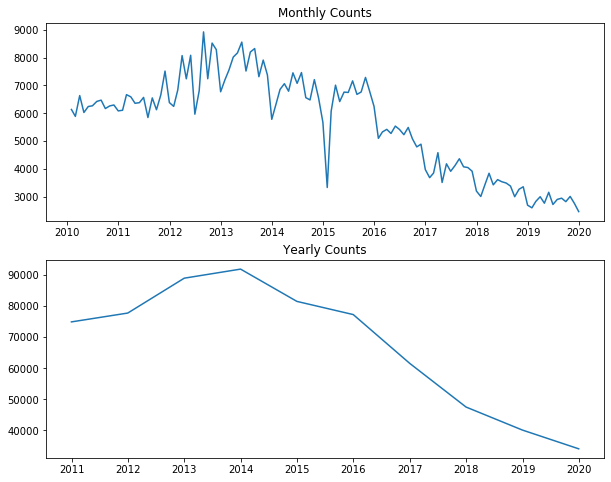

In [60]:
fig, ax = plt.subplots(2, figsize=(10,8))
ax[0].plot(monthly_counts)
ax[0].set_title('Monthly Counts')
ax[1].plot(yearly_counts);
ax[1].set_title('Yearly Counts')
plt.show()

### Analysis
- The **mean values** of the news title in a year and a month is **5630 and 67571** respectively. 
- From the two histgram above, we can see that the **distribution of the dataset is not even at all**.
- From the yearly counts, we can see that the number of news increased from 2011 until around 2014. After that, this number started to decrease until now. 
- Since we are interested about the top topics of the past ten years, but **it's unlikely to apply the functions in such a big dataset**. Thus, we could **create a random data sample** which is 10% of the past ten years dataset. Before we can find other better ways to reduce the data dimension, **we assume that this random sample data is representative enough of the decade news titles**. 

In [61]:
# Here we get random 10% data of the decade newstitle as our sample
# The sample size is same as the mean of yearly news titles

sample_title = decade_data.sample(frac=0.1, replace=True, random_state=1)
print(sample_title.head())
sample_title.shape[0]
sample_title


        publish_date                                      headline_text
638342    2011-09-10      japanese minister resigns over radiation joke
1002060   2015-12-26                               boxing day test wrap
981229    2015-09-25  canberra teen sentenced to jail over jewellery...
1001568   2015-12-22                            vinnies illegal dumping
881708    2014-06-15                       interview marcus bontempelli


,publish_date,headline_text
638342,2011-09-10,japanese minister resigns over radiation joke
1002060,2015-12-26,boxing day test wrap
981229,2015-09-25,canberra teen sentenced to jail over jewellery...
1001568,2015-12-22,vinnies illegal dumping
881708,2014-06-15,interview marcus bontempelli
...,...,...
976290,2015-09-03,grandstand thursday september 3
795720,2013-06-18,china launches its first carbon trading scheme
705566,2012-07-02,abuse victims speak of navy base violence
647039,2011-10-23,all blacks win will seal the deal for key


In [62]:
pip install nltk

Processing /home/jovyan/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266/nltk-3.5-py3-none-any.whl
  Using cached regex-2020.4.4-cp37-cp37m-manylinux2010_x86_64.whl (679 kB)
Note: you may need to restart the kernel to use updated packages.


### Data cleanning
- Now we **get the sample dataset ready** with an accaptable size. To apply tf or tfidf on our dataset, **further cleanning need to be done** to transfer our dataset from a list of string to tokens. The process includes **tokenization, stop-word removal and stemming**, followed by **vectorization** for model training. These will be done with nltk and scikitlearn library.

In [63]:
#import libraries
import numpy as np
import re #for tokenization
import nltk #nlp library for stop-words
import string #for punctuation (in case there's any)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #for tf tfidf


In [64]:
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer() #for stemming tokens to reduce variations of tokens


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:

def clean_txt(text):
    ## define the functions to pre-process the text, this will be used as analyzer in our vectorizer
    #This function takes a list of text as input, output a list of clean tokens
    # The clean process includes convert to lower case, remove punctuation, tokenization, stop-word removal(from the default sk learn stopword list)and stemmeing, a porter stemmer was used here. 

    text = "".join([word.lower()for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopword]
    return text


def get_top_n_vectors(vectorizer, text, n):
    # This function takes vectorizer, text and top n numbers of vectors as input
    # The output will be a sorted dateframe(with the top n vectors weight in ascending orders) with two columns: term and weight
    
    X = vectorizer.fit_transform(text)
    print(X.shape)
    weight = np.asarray(X.mean(axis=0)).ravel().tolist()
    weight_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': weight})
    sorted_df = weight_df.sort_values(by='weight', ascending=False).head(n)
    return sorted_df


def plot_top_n_vectors(sorted_df):
    # This function takes a sorted dataframe as input then give a plot of top n weighted vectors
    plt.figure(figsize=(20,4))
    plt.plot(sorted_df['term'],sorted_df['weight'])
    plt.xticks(sorted_df['term'] ,rotation='vertical')
    plt.show()
    

### Analysis
- We would like to apply both 'tf' and 'tfidf' on our dtaset to compare the result here. 

In [66]:
#Since now we have the funtion to clean up the data string into clean tokens, next step is to convert the tokens into vectors for machine to process.
# This is for word count 
tf_vectorizer =  CountVectorizer(analyzer = clean_txt)   
# This is for tfidf
tfidf_vectorizer = TfidfVectorizer(analyzer = clean_txt)


(67571, 24099)


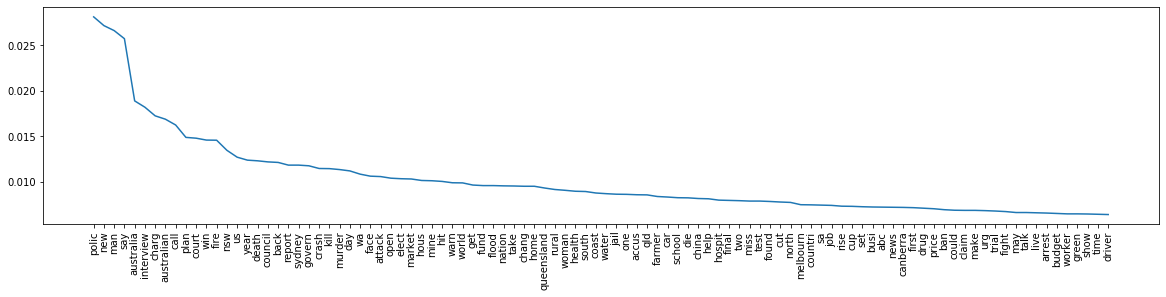

(67571, 24099)


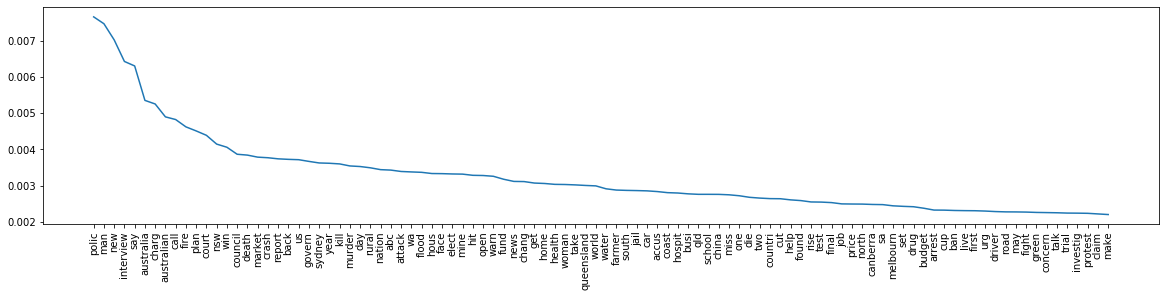

In [67]:
# Implement word count(weight) on sample data and plot the most 100 frequent terms
sorted_tf = get_top_n_vectors(tf_vectorizer,sample_title['headline_text'], 100)
plot_top_n_vectors(sorted_tf)

# implment tfidf on sample data and plot the most 100 frequent terms
sorted_tfidf = get_top_n_vectors(tfidf_vectorizer,sample_title['headline_text'], 100)
plot_top_n_vectors(sorted_tfidf)


### Analysis:
- Through the implementation if 'tf' and 'tfidf', we are able to get the top 100 weighted terms in the sample dataset(over 67571 news tiltles which are more than 24k tokens).
- As can be seen from the plots above, both the 'tf' and 'tfidf' weight decreased gradually, and **the lines have been flattend before the 100 terms**. This gives us a sign that the most frequent terms can be found before the 100 terms. 
- Terms such as **'police, man, fire, crash, interview, charge, win .etc'** rank very high in **both term frequency and tfidf.**  However, single terms can still **hardly give us a meaningful insight about the 'topics'**.
- To improve this, we shall try to implement **N-gram** to link terms together. For handling large scale dataset, **tri-gram will be consider suitable** to implement here. 

(67571, 273350)


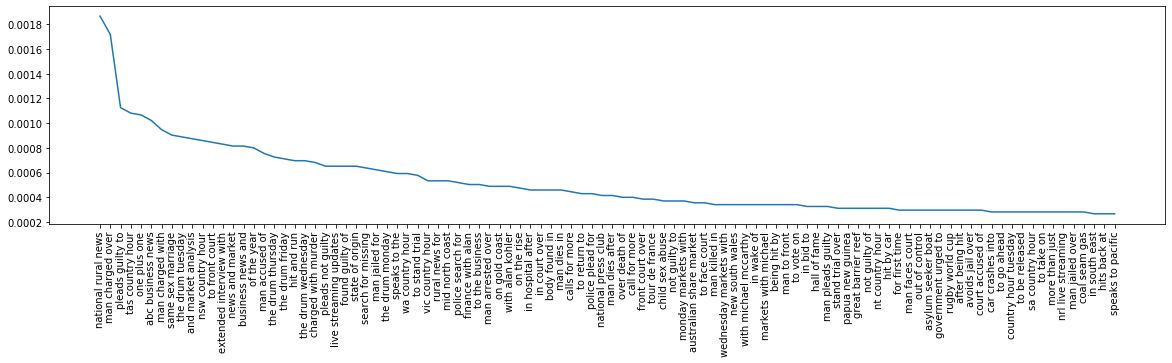

                       term    weight
155925  national rural news  0.001865
143236     man charged over  0.001717
182556     pleads guilty to  0.001125
230625     tas country hour  0.001080
171362         one plus one  0.001066
...                     ...       ...
143486      man jailed over  0.000281
50640         coal seam gas  0.000281
120146        in south east  0.000266
111594         hits back at  0.000266
220126    speaks to pacific  0.000266

[100 rows x 2 columns]
(67571, 273350)


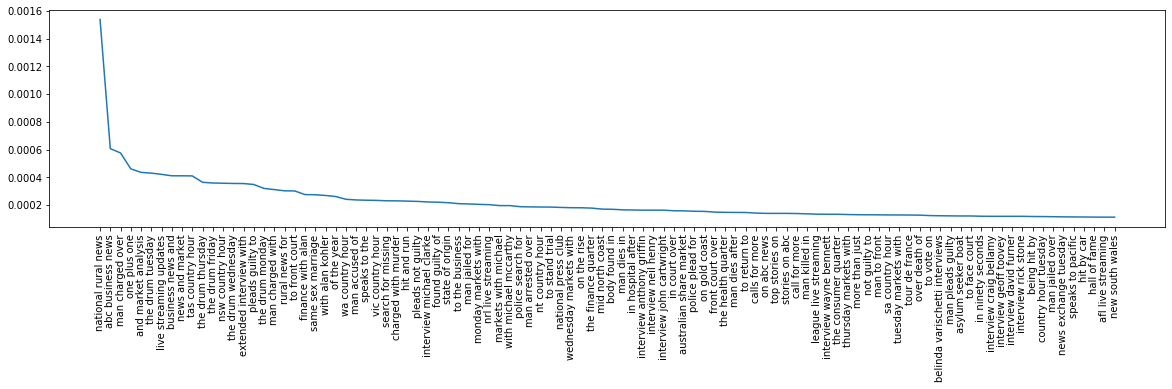

                       term    weight
155925  national rural news  0.001538
2729      abc business news  0.000607
143236     man charged over  0.000575
171362         one plus one  0.000461
12613   and market analysis  0.000435
...                     ...       ...
220126    speaks to pacific  0.000114
111377           hit by car  0.000113
106159         hall of fame  0.000113
6389     afl live streaming  0.000112
158170      new south wales  0.000112

[100 rows x 2 columns]


In [68]:
# this is for trigram in a tf.idf vecterizer
trigram_tf_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_tfidf_vectorizer= TfidfVectorizer(ngram_range =(3, 3))

# implement a trigram on tfidf vecterizer 
sorted_trigram = get_top_n_vectors(trigram_tf_vectorizer, sample_title['headline_text'], 100)
plot_top_n_vectors(sorted_trigram)
print(sorted_trigram)

sorted_trigram2 = get_top_n_vectors(trigram_tfidf_vectorizer, sample_title['headline_text'], 100)
plot_top_n_vectors(sorted_trigram2)
print(sorted_trigram2)

### Analysis
- After applying tri-gram on sample dataset, we are able to print the top 100 ranked grams with both 'tf vectorizer' and 'tfidf vectorizer'. These grams **give us more insightful information on the topics than single terms**. 

- When comparing the two plots of trigram with 'tf vectorizer' and 'tfidf vectorizer', we found that **many trigrams of the two plots are overlapped**, I assume that is because our **dataset are short news titles that are unlikely to include same words in one title/document**. This makes it less different whether we choose to use 'tf' or 'tfidf' as our stategy here.

### Topic insights

- **'Same sex marriage'** is a high ranked topic. This is because Australia legalised same-sex marriage in December 2017, which has caused a heated discussion among the nation.

- **'Social news'** is also a widely discussed topic, this can be seen from the high ranked terms such as **'not guilty to','man killed in','being hit by','police','ctash','murder' etc**. 

- **'Business news'** is another hot topic within past decade, indicated by high ranked term **'the consumer quarter', 'market analysis', 'finance with alan' etc**.

- However, high ranked tri-gram such as **'one plus one', 'the drum ', 'Tas country hour', 'National press club '** are the names of TV/broadcast programmes owned by ABC News. **These grams are actually not adding much value to the reader's insight**. To get rid of these less useful terms, a **customized stop words list** can be added at pre-processing stage later.

### Future work

- Though **tri-gram works well** on our sample dataset, it has **greatly increased the dimension**  compare with single terms. For 67571 news_titles, the dimension of tri-gram went from 24k to 273k. **It is unrealistic to apply tri-gram on the whole dataset**. 

- To further reduce the dimension and make the topics clear, a **topic model** would be a better option, here LDA (Latent Dirichlet allocation) will be choose as our future approach. 

### References:


https://www.kaggle.com/rtatman/tutorial-getting-n-grams

https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda#Topic-Modelling-with-LSA-and-LDA
